# 0. Overview
This notebook ...  
   *//TO-DO*

# 1. Import data

In [ ]:
# INSTALL
#!pip install --user xgboost pyod imutils

In [73]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import imutils
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loda import LODA
from pyod.models.vae import VAE
from pyod.models.xgbod import XGBOD
from pyod.models.abod import ABOD
from sklearn.model_selection import train_test_split

In [4]:
def quantify_image(image, bins=(4, 6, 3)):
    # compute a 3D color histogram over the image and normalize it
    hist = cv2.calcHist([image], [0, 1, 2], None, [16, 16, 16],
        [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    # return the histogram
    return hist

In [5]:
images=[]
features = []
PATH = 'GTSRB\Final_Training\Images'
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.ppm'))):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = imutils.resize(img, width=100)
    images.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 39209/39209 [03:05<00:00, 211.34it/s]


In [6]:
images = np.asarray(images)
images.shape

C:\Users\Carlos\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(39209,)

In [7]:
labels = []
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.csv'))):
    labels.append(np.genfromtxt(filename, delimiter=';',skip_header=1,dtype='int32'))

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 73.61it/s]


In [8]:
labels = np.vstack(labels)[:,-1]
labels.shape

(39209,)

# 2. Combine data

In [9]:
all_data = np.column_stack((images,labels))

In [10]:
import pandas as pd

df = pd.DataFrame(data=all_data)
df = df.rename(columns={0: "ppm_image", df.columns[-1]: "label"})
df.tail()

,ppm_image,label
39204,"[[[13, 11, 12], [13, 11, 12], [11, 11, 12], [1...",42
39205,"[[[11, 9, 10], [11, 9, 10], [10, 9, 11], [10, ...",42
39206,"[[[10, 10, 12], [11, 11, 13], [12, 12, 14], [1...",42
39207,"[[[14, 13, 15], [14, 13, 15], [13, 13, 15], [1...",42
39208,"[[[10, 9, 11], [10, 9, 11], [10, 9, 11], [10, ...",42


In [11]:
df_stop = df[df.iloc[:,-1] == 14]
df_stop = df_stop.reset_index(drop=True)
df_stop.shape

(780, 2)

In [12]:
features = []
for img in df_stop['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)
df_stop = pd.concat([df_stop, pd.DataFrame(features)], axis=1)
df_stop.shape

(780, 4098)

# 3. Visualize data

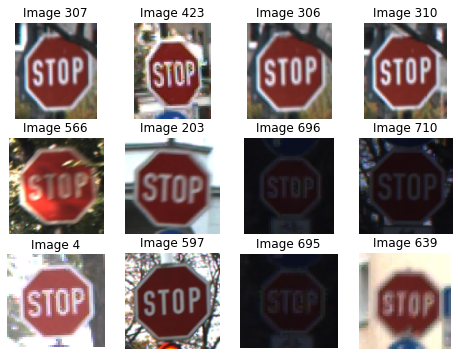

In [13]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(df_stop.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(df_stop['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

In [14]:
df_train, df_test = train_test_split(df_stop, test_size=0.15)

print(df_train.shape)
print(df_test.shape)

(663, 4098)
(117, 4098)


In [15]:
df_outliers = df[df['label']==9].sample(10)
df_outliers = df_outliers.append(df[df['label']==17].sample(10))
df_outliers.reset_index(drop=True, inplace=True)
features = []
for img in df_outliers['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)

df_outliers = pd.concat([df_outliers, pd.DataFrame(features)], axis=1)
df_outliers.shape

(20, 4098)

In [16]:
df_test = df_test.append(df_outliers)
df_test.shape

(137, 4098)

In [17]:
df_train.head()

,ppm_image,label,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
513,"[[[232, 251, 245], [232, 251, 245], [232, 251,...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.008852,0.393131
97,"[[[20, 22, 22], [20, 22, 22], [21, 22, 23], [2...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.002373,0.009492,0.020467,0.132292
335,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000772,0.012608,0.943813
623,"[[[50, 92, 92], [27, 45, 43], [36, 38, 33], [3...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000382,0.000382,0.001147,0.003825,0.266209
66,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.009738,0.947820


# 1. Isolation Forest

In [117]:
# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
model_if = IForest(n_estimators=100, contamination=0.03, n_jobs=-1, random_state=42)
model_if.fit(df_train.iloc[:,2:])

[INFO] fitting anomaly detection model...


IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=42, verbose=0)

In [118]:
preds_if = model_if.predict(df_test.iloc[:,2:])
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0])

In [120]:
df_test.iloc[:,[0,1]][preds_if==1]

,ppm_image,label
135,"[[[56, 67, 54], [55, 66, 53], [52, 61, 49], [4...",14
63,"[[[138, 162, 178], [138, 162, 178], [137, 161,...",14
11,"[[[42, 41, 40], [42, 41, 40], [52, 45, 43], [5...",17
14,"[[[122, 137, 170], [122, 137, 170], [122, 137,...",17


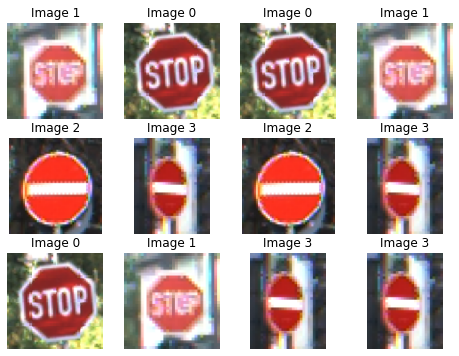

In [121]:
iforest_res = df_test.iloc[:,[0,1]][preds_if==1].reset_index(drop=True)
rand_grid = np.random.randint(iforest_res.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(iforest_res['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

# 2. Auto Encoders

In [96]:
# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
model_ae = AutoEncoder(epochs=10, random_state=42, contamination=0.03)
model_ae.fit(df_train.iloc[:,2:])

[INFO] fitting anomaly detection model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_12 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_13 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                262208    
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dens

AutoEncoder(batch_size=32, contamination=0.03, dropout_rate=0.2, epochs=10,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000001EC219DE3A0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=42, validation_size=0.1, verbose=1)

In [122]:
preds_ae = model_ae.predict(df_test.iloc[:,2:])
df_test.iloc[:,[0,1]][preds_ae==1]

,ppm_image,label
31,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",14
214,"[[[92, 106, 117], [92, 106, 117], [99, 108, 11...",14
230,"[[[116, 99, 83], [100, 93, 77], [94, 95, 83], ...",14
64,"[[[213, 245, 220], [213, 245, 220], [214, 244,...",14
135,"[[[56, 67, 54], [55, 66, 53], [52, 61, 49], [4...",14
136,"[[[55, 68, 53], [53, 66, 51], [48, 60, 45], [4...",14
213,"[[[72, 93, 115], [72, 93, 115], [75, 95, 117],...",14
63,"[[[138, 162, 178], [138, 162, 178], [137, 161,...",14
3,"[[[54, 48, 41], [51, 47, 40], [40, 44, 38], [4...",9
7,"[[[59, 59, 53], [58, 60, 54], [56, 62, 60], [4...",9


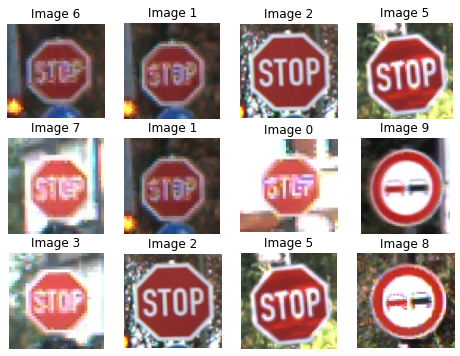

In [123]:
ae_res = df_test.iloc[:,[0,1]][preds_ae==1].reset_index(drop=True)
rand_grid = np.random.randint(ae_res.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(ae_res['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

# 3. LODA

In [99]:
model_loda = LODA(contamination=0.03, n_bins=10, n_random_cuts=100)
model_loda.fit(df_train.iloc[:,2:])

LODA(contamination=0.03, n_bins=10, n_random_cuts=100)

In [124]:
preds_loda = model_loda.predict(df_test.iloc[:,2:])
df_test.iloc[:,[0,1]][preds_loda==1]

,ppm_image,label
384,"[[[198, 210, 222], [204, 215, 227], [228, 232,...",14
85,"[[[98, 88, 84], [105, 96, 91], [115, 108, 101]...",14
191,"[[[193, 213, 222], [193, 213, 222], [193, 213,...",14
136,"[[[55, 68, 53], [53, 66, 51], [48, 60, 45], [4...",14
44,"[[[255, 255, 254], [253, 253, 252], [205, 207,...",14
213,"[[[72, 93, 115], [72, 93, 115], [75, 95, 117],...",14


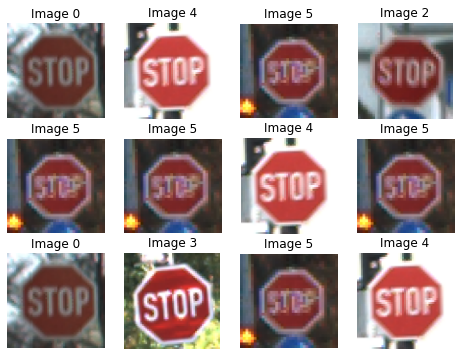

In [125]:
loda_res = df_test.iloc[:,[0,1]][preds_loda==1].reset_index(drop=True)
rand_grid = np.random.randint(loda_res.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(loda_res['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

# 4. VAE

In [104]:
model_vae = VAE(random_state=42, contamination=0.03, epochs = 10)

model_vae.fit(df_train.iloc[:,2:])

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 4096)         16781312    input_7[0][0]                    
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 128)          524416      dense_40[0][0]                   
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 128)          0           dense_41[0][0]                   
____________________________________________________________________________________________

VAE(batch_size=32, capacity=0.0, contamination=0.03,
  decoder_neurons=[32, 64, 128], dropout_rate=0.2,
  encoder_neurons=[128, 64, 32], epochs=10, gamma=1.0,
  hidden_activation='relu', l2_regularizer=0.1, latent_dim=2,
  loss=<function mean_squared_error at 0x000001EC219DE3A0>,
  optimizer='adam', output_activation='sigmoid', preprocessing=True,
  random_state=42, validation_size=0.1, verbose=1)

In [126]:
preds_vae = model_vae.predict(df_test.iloc[:,2:])
df_test.iloc[:,[0,1]][preds_vae==1]

,ppm_image,label
31,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",14
214,"[[[92, 106, 117], [92, 106, 117], [99, 108, 11...",14
230,"[[[116, 99, 83], [100, 93, 77], [94, 95, 83], ...",14
64,"[[[213, 245, 220], [213, 245, 220], [214, 244,...",14
135,"[[[56, 67, 54], [55, 66, 53], [52, 61, 49], [4...",14
136,"[[[55, 68, 53], [53, 66, 51], [48, 60, 45], [4...",14
213,"[[[72, 93, 115], [72, 93, 115], [75, 95, 117],...",14
63,"[[[138, 162, 178], [138, 162, 178], [137, 161,...",14
3,"[[[54, 48, 41], [51, 47, 40], [40, 44, 38], [4...",9
7,"[[[59, 59, 53], [58, 60, 54], [56, 62, 60], [4...",9


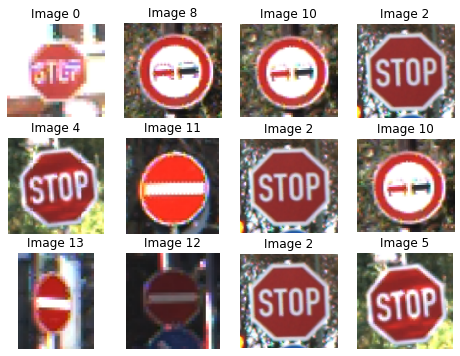

In [127]:
vae_res = df_test.iloc[:,[0,1]][preds_vae==1].reset_index(drop=True)
rand_grid = np.random.randint(vae_res.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(vae_res['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

# 5. ABOD

In [90]:
model_abod = ABOD(contamination=0.03)

model_abod.fit(df_train.iloc[:,2:])

ABOD(contamination=0.03, method='fast', n_neighbors=5)

In [128]:
preds_abod = model_abod.predict(df_test.iloc[:,2:])
df_test.iloc[:,[0,1]][preds_abod==1]

,ppm_image,label
63,"[[[138, 162, 178], [138, 162, 178], [137, 161,...",14
0,"[[[42, 38, 35], [42, 38, 35], [42, 38, 35], [4...",9
1,"[[[164, 174, 186], [164, 174, 186], [164, 174,...",9
6,"[[[24, 20, 19], [24, 20, 19], [24, 20, 19], [2...",9
9,"[[[144, 154, 164], [144, 154, 164], [144, 154,...",9
11,"[[[42, 41, 40], [42, 41, 40], [52, 45, 43], [5...",17
12,"[[[46, 42, 33], [46, 42, 33], [45, 40, 29], [4...",17
14,"[[[122, 137, 170], [122, 137, 170], [122, 137,...",17
15,"[[[156, 114, 44], [156, 114, 44], [147, 109, 4...",17
16,"[[[55, 49, 40], [55, 49, 40], [53, 47, 37], [5...",17


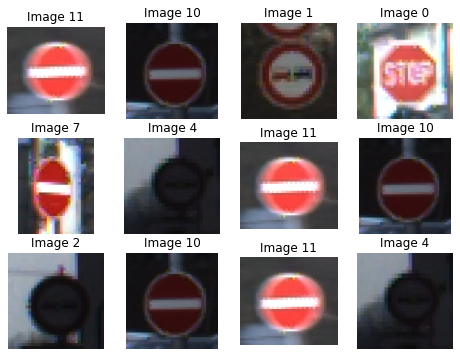

In [129]:
abod_res = df_test.iloc[:,[0,1]][preds_abod==1].reset_index(drop=True)
rand_grid = np.random.randint(abod_res.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(abod_res['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

# Evaluation:

In [130]:
true = df_test['label']!=14

In [135]:
from sklearn.metrics import accuracy_score
print('IForest accuracy: {:.2f}'.format(float(accuracy_score(true, preds_if))))
print('AE accuracy: {:.2f}'.format(float(accuracy_score(true, preds_ae))))
print('LODA accuracy: {:.2f}'.format(float(accuracy_score(true, preds_loda))))
print('VAE accuracy: {:.2f}'.format(float(accuracy_score(true, preds_vae))))
print('ABOD accuracy: {:.2f}'.format(float(accuracy_score(true, preds_abod))))

IForest accuracy: 0.85
AE accuracy: 0.85
LODA accuracy: 0.81
VAE accuracy: 0.85
ABOD accuracy: 0.93


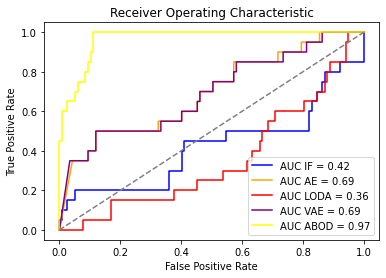

In [158]:
from sklearn import metrics 

fpr_if, tpr_if, threshold_if = metrics.roc_curve(true, model_if.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_ae, tpr_ae, threshold_ae = metrics.roc_curve(true, model_ae.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_loda, tpr_loda, threshold_loda = metrics.roc_curve(true, model_loda.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_vae, tpr_vae, threshold_vae = metrics.roc_curve(true, model_vae.predict_proba(df_test.iloc[:,2:])[:,1])
fpr_abod, tpr_abod, threshold_abod = metrics.roc_curve(true, model_abod.predict_proba(df_test.iloc[:,2:])[:,1])

roc_auc_if = metrics.auc(fpr_if, tpr_if)
roc_auc_ae = metrics.auc(fpr_ae, tpr_ae)
roc_auc_loda = metrics.auc(fpr_loda, tpr_loda)
roc_auc_vae = metrics.auc(fpr_vae, tpr_vae)
roc_auc_abod = metrics.auc(fpr_abod, tpr_abod)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_if, tpr_if, 'b', color = 'blue', label = 'AUC IF = %0.2f' % roc_auc_if)
plt.plot(fpr_ae, tpr_ae, 'b', color = 'orange', label = 'AUC AE = %0.2f' % roc_auc_ae)
plt.plot(fpr_loda, tpr_loda, 'b', color = 'red', label = 'AUC LODA = %0.2f' % roc_auc_loda)
plt.plot(fpr_vae, tpr_vae, 'b', color = 'purple', label = 'AUC VAE = %0.2f' % roc_auc_vae)
plt.plot(fpr_abod, tpr_abod, 'b', color = 'yellow', label = 'AUC ABOD = %0.2f' % roc_auc_abod)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color = 'grey')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [155]:
model_abod.predict_proba(df_test.iloc[:,2:])[:,1]

array([0.9998725 , 0.999605  , 0.99832736, 0.99182835, 0.98823073,
       0.99987615, 0.89733418, 0.99997378, 0.99873919, 0.95521478,
       0.8604435 , 0.99933542, 0.99997263, 0.99995244, 0.99989735,
       0.99929141, 0.99810417, 0.99998101, 0.99023624, 0.99860462,
       0.98756359, 0.99995631, 0.99811555, 0.91539956, 0.99998227,
       0.99806723, 0.9992853 , 0.99875149, 0.99031736, 0.99940219,
       0.99959283, 0.99818624, 0.9994205 , 0.99982652, 0.99713363,
       0.98454632, 0.99948483, 0.989645  , 0.99954207, 0.99736683,
       0.99995719, 0.99966938, 0.99980134, 0.9900419 , 0.93802165,
       0.99779585, 0.99987742, 0.9995965 , 0.94117429, 0.9998878 ,
       0.99854583, 0.9997747 , 0.99174163, 0.99976466, 0.9747166 ,
       0.94198047, 0.99959404, 0.9997081 , 0.99997791, 0.99372952,
       0.99979756, 0.99221512, 0.93572056, 0.99959787, 0.99279689,
       0.99915716, 0.99211736, 0.9962135 , 0.99996783, 0.99985009,
       0.9997622 , 0.9993635 , 0.99833792, 0.9980954 , 0.97430